In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('./fish_measurements.csv', header = None, names = ['species','weight','length_1','length_2','length_3', 'height','width'])

In [3]:
data.head()

,species,weight,length_1,length_2,length_3,height,width
0,Bream,242.0,23.2,25.4,30.0,38.4,13.4
1,Bream,290.0,24.0,26.3,31.2,40.0,13.8
2,Bream,340.0,23.9,26.5,31.1,39.8,15.1
3,Bream,363.0,26.3,29.0,33.5,38.0,13.3
4,Bream,430.0,26.5,29.0,34.0,36.6,15.1


In [4]:
data.shape

(85, 7)

In [5]:
data['species'].unique()

array(['Bream', 'Roach', 'Smelt', 'Pike'], dtype=object)

There are 4 unique species in the dataset, the usual way of specifing number of clusters for KMeans is by the different type of clusters we are expecting. 

But their are some cases where we don't know the unique species. Inertia will help us to find n_clusters in such cases

In [6]:
#lets seperate the species column from rest of the columns 
species = data.iloc[:,0]
samples = data.iloc[:,1:]

samples.head()

,weight,length_1,length_2,length_3,height,width
0,242.0,23.2,25.4,30.0,38.4,13.4
1,290.0,24.0,26.3,31.2,40.0,13.8
2,340.0,23.9,26.5,31.1,39.8,15.1
3,363.0,26.3,29.0,33.5,38.0,13.3
4,430.0,26.5,29.0,34.0,36.6,15.1


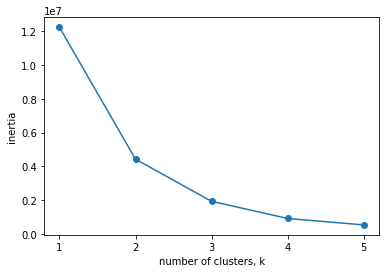

In [7]:
ks = range(1, 6)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)

    # Fit model to samples
    model.fit(samples)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#lets try building a KMeans clustering model 

In [8]:
model = KMeans(n_clusters = 4)
model.fit(samples)

labels = model.predict(samples)

In [9]:
print(labels)

[0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2
 2 2 2 2 2 1 1 3 3 3 3]


it is hard to interprete the predicted labels lets get more interpretation by visualizing the prediction

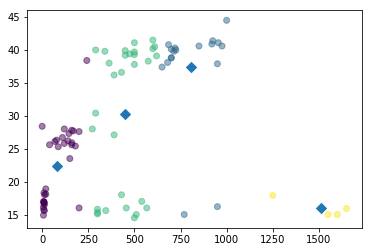

In [10]:
#lets see how the species are clustered based on the weight
xs = samples.iloc[:,0] #weight column
ys = samples.iloc[:,4] #height column

plt.scatter(xs, ys, c = labels, alpha = 0.5)
centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,4]

plt.scatter(centroids_x, centroids_y, marker = 'D', s = 50)
plt.show()

In [11]:
#lets create a dataframe of predicted labels and species actually the were
df = pd.DataFrame({'labels': labels, 'species': species})

In [12]:
#lets do a crosstab evaluation to verify the quality of our clustering
ct = pd.crosstab(df['labels'], df['species'])
print(ct)

species  Bream  Pike  Roach  Smelt
labels                            
0            1     1     17     14
1           16     2      0      0
2           17    10      3      0
3            0     4      0      0


As we can see that the clustering is not good enough, lets see why is that

In [13]:
data.describe()

,weight,length_1,length_2,length_3,height,width
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,431.758824,27.338824,29.557647,33.120000,28.076471,12.865882
std,380.933962,11.289450,12.185045,13.197292,10.351543,2.117476
min,0.000000,9.300000,9.800000,10.800000,14.500000,8.700000
25%,120.000000,19.400000,21.000000,23.700000,16.900000,11.000000
50%,390.000000,28.400000,30.700000,35.000000,27.100000,13.700000
75%,650.000000,32.700000,36.000000,40.600000,39.200000,14.700000
max,1650.000000,59.000000,63.400000,68.000000,44.500000,16.100000


As we can see each varibles have different standard diviations(i.e. varience), also different means. 
lets do some feature scaling to bring them all to same scale 

In [14]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters= 4)

pipeline = Pipeline([('Scaler',scaler), ('KMeans',kmeans)])
pipeline.fit(samples)

labels2 = pipeline.predict(samples)

df2 = pd.DataFrame({'labels': labels2, 'species': species})

ct2 = pd.crosstab(df2['labels'], df2['species'])

print(ct2)

species  Bream  Pike  Roach  Smelt
labels                            
0            1     0     19      1
1            0    17      0      0
2           33     0      1      0
3            0     0      0     13


Seems a better clustering now!!!!!

In [15]:
temp_df = pd.DataFrame(pipeline.named_steps['Scaler'].transform(samples))
temp_df.head()


,0,1,2,3,4,5
0,-0.501097,-0.368786,-0.343234,-0.237815,1.003212,0.253740
1,-0.374343,-0.297502,-0.268935,-0.146348,1.158696,0.443765
2,-0.242308,-0.306413,-0.252424,-0.153970,1.139261,1.061347
3,-0.181572,-0.092563,-0.046036,0.028965,0.964342,0.206233
4,-0.004645,-0.074743,-0.046036,0.067076,0.828293,1.061347


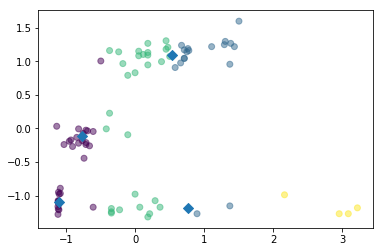

In [17]:
#lets see how the species are clustered based on the weight
xs = temp_df.iloc[:,0]
ys = temp_df.iloc[:,4] 

plt.scatter(xs, ys, c = labels, alpha = 0.5)
centroids = pipeline.named_steps['KMeans'].cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,4]

plt.scatter(centroids_x, centroids_y, marker = 'D', s = 50)
plt.show()